In [2]:
import pandas as pd
import numpy as np
from surprise import SVD, accuracy, SVDpp
from surprise import Dataset, Reader
import matplotlib.pyplot as plt

In [3]:
train_data = pd.read_csv('train.csv')
valid_data = pd.read_csv('valid.csv')
test_data = pd.read_csv('test.csv')

In [7]:
print(len(train_data), len(valid_data), len(test_data))

905894 113236 113237


In [8]:
train_data.head()

,user,item,rating
0,113920,108234,0
1,40482,15627,4
2,59345,17898,3
3,73568,143053,2
4,5015,20171,5


In [28]:
# let's only use 1/10 of the train data
# train_data = train_data.sample(frac=0.1, random_state=42)

In [9]:
reader = Reader(rating_scale=(0, 5))
train_dataset = Dataset.load_from_df(train_data[['user', 'item', 'rating']], reader)
trainset = train_dataset.build_full_trainset()

In [10]:
valid_dataset = Dataset.load_from_df(valid_data[['user', 'item', 'rating']], reader)
validset = valid_dataset.build_full_trainset().build_testset()

In [6]:
# calculate the mean and std of the validation set
mean = train_data['rating'].mean()
var = train_data['rating'].var()
print(mean, var)
mean = valid_data['rating'].mean()
var = valid_data['rating'].var()
print(mean, var)


4.41098848209614 1.6014121493971378
4.413790667278957 1.5900863204307607
4.408461898496075 1.5946025275430167


In [12]:
users_in_train = train_data['user'].unique()
items_in_train = train_data['item'].unique()
users_in_valid = valid_data['user'].unique()
items_in_valid = valid_data['item'].unique()
items_in_test = test_data['item'].unique()


In [13]:
print("users in train: ", len(users_in_train))
print("users in valid: ", len(users_in_valid))
print("users not seen in train: ", len(set(users_in_valid) - set(users_in_train)))


users in train:  192306
users in valid:  41194
users not seen in train:  17445


In [14]:
print("items in train: ", len(items_in_train))
print("items in valid: ", len(items_in_valid))
print("items not seen in train: ", len(set(items_in_valid) - set(items_in_train)))

items in train:  211274
items in valid:  63487
items not seen in train:  10761


In [15]:
# merge train and valid frame
cv_data = pd.concat([train_data, valid_data], ignore_index=True)
cv_dataset = Dataset.load_from_df(cv_data[['user', 'item', 'rating']], reader)

In [16]:
from surprise.model_selection import GridSearchCV
param_grid = {'n_factors': [1, 2, 5, 10], 'lr_all': [2e-3, 5e-3, 0.01]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)


{'rmse': {'n_factors': 1, 'lr_all': 0.005}}
{'rmse': 1.2146720718719497}


In [114]:
param_grid = {'reg_bu': [0.005, 0.01, 0.02], 'reg_bi': [0.2, 0.4, 1], 'reg_all': [0.2], 'n_factors': [1], 'lr_all': [0.005]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)

{'rmse': {'reg_bu': 0.005, 'reg_bi': 0.4, 'reg_all': 0.2, 'n_factors': 1, 'lr_all': 0.005}}
{'rmse': 1.2150348501852548}


In [118]:
param_grid = {'n_factors': [1], 'lr_all': [0.005], 'reg_bu': [0.005, 0.01], 'reg_bi': [0.4, 0.5], 'reg_pu': [0.4, 0.5], 'reg_qi': [0.005, 0.1, 0.2]}
model_gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5, n_jobs=-1)
model_gs.fit(cv_dataset)
print(model_gs.best_params)
print(model_gs.best_score)


{'rmse': {'n_factors': 1, 'lr_all': 0.005, 'reg_bu': 0.005, 'reg_bi': 0.5, 'reg_pu': 0.5, 'reg_qi': 0.1}}
{'rmse': 1.2148617303712848}


In [17]:
# train the model with the best params
model = SVD(n_factors=1, reg_bu=0.005, reg_bi=0.5, reg_pu=0.5, reg_qi=0.1, lr_all=0.005)
model.fit(cv_dataset.build_full_trainset())

In [18]:

testset = Dataset.load_from_df(test_data[['user', 'item', 'rating']], reader).build_full_trainset().build_testset()

In [19]:
predictions = model.test(testset)
mse = accuracy.mse(predictions=predictions)

MSE: 1.4534


In [20]:
predictions[:20]

[Prediction(uid=577, iid=24831, r_ui=4.0, est=4.268314503019521, details={'was_impossible': False}),
 Prediction(uid=577, iid=30750, r_ui=4.0, est=4.21765022771968, details={'was_impossible': False}),
 Prediction(uid=577, iid=20947, r_ui=4.0, est=4.268314503019521, details={'was_impossible': False}),
 Prediction(uid=9213, iid=77881, r_ui=4.0, est=4.1100053848218945, details={'was_impossible': False}),
 Prediction(uid=9213, iid=45515, r_ui=5.0, est=4.14318179057915, details={'was_impossible': False}),
 Prediction(uid=9213, iid=20364, r_ui=4.0, est=3.999168195198272, details={'was_impossible': False}),
 Prediction(uid=9213, iid=5715, r_ui=4.0, est=3.565975612876017, details={'was_impossible': False}),
 Prediction(uid=9213, iid=59923, r_ui=4.0, est=4.017359888946895, details={'was_impossible': False}),
 Prediction(uid=9213, iid=9254, r_ui=4.0, est=4.03582285202197, details={'was_impossible': False}),
 Prediction(uid=9213, iid=41232, r_ui=2.0, est=4.120945233834083, details={'was_impossibl

(array([  6033.,   1287.,   1390.,   4071., 100455.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

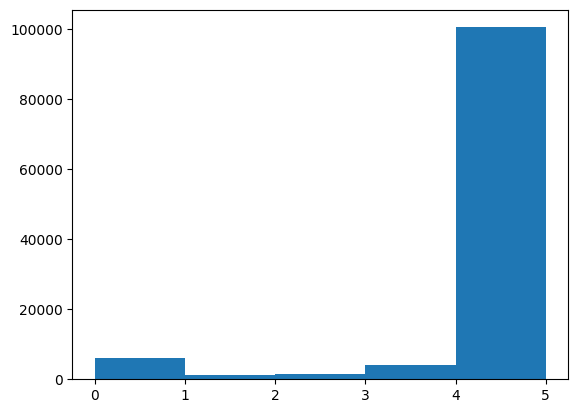

In [4]:
plt.hist(valid_data['rating'], bins=5)

(array([ 48801.,  10227.,  11272.,  32518., 803076.]),
 array([0., 1., 2., 3., 4., 5.]),
 <BarContainer object of 5 artists>)

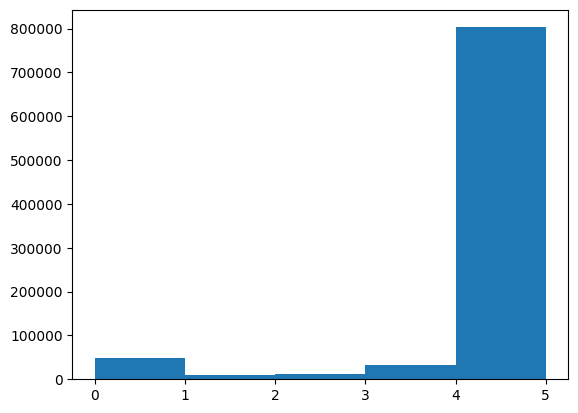

In [5]:
plt.hist(train_data['rating'], bins=5)

(array([  75., 1360., 2512., 1079.,  668.,   88.,   64.,   55.,   97.,
         234.,  128.,   10.,   11.,   13.,   15.,   79.,   47.,   13.,
           3.,    6.,    8.,   19.,   89.,   27.,   11.,   18.,   11.,
          31.,  187.,   65.]),
 array([0.00567115, 0.16636238, 0.32705361, 0.48774483, 0.64843606,
        0.80912729, 0.96981851, 1.13050974, 1.29120096, 1.45189219,
        1.61258342, 1.77327464, 1.93396587, 2.09465709, 2.25534832,
        2.41603955, 2.57673077, 2.737422  , 2.89811323, 3.05880445,
        3.21949568, 3.3801869 , 3.54087813, 3.70156936, 3.86226058,
        4.02295181, 4.18364304, 4.34433426, 4.50502549, 4.66571671,
        4.82640794]),
 <BarContainer object of 30 artists>)

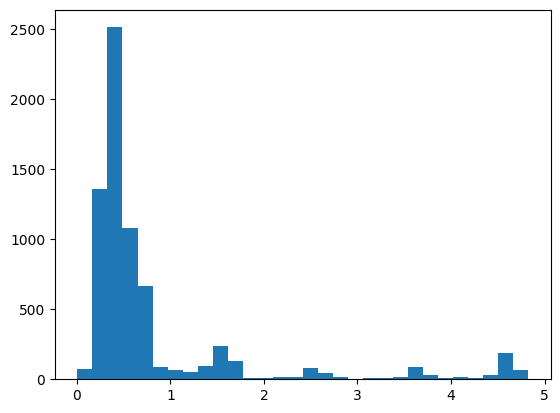

In [41]:
errors = [abs(p.r_ui - p.est) for p in predictions]
# draw a histogram of the errors
plt.hist(errors, bins=5)